In [1]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_json("/Users/n.anokhin/Desktop/seminar-2-data.json", lines=True)
data["rnd"] = np.random.random(len(data))

data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2022-02-28 08:57:07.615,3255,2659,1.00,0.000844,37339.0,{'AA': 'C'},0.564124
1,next,2022-02-28 08:57:07.623,3255,37339,0.19,0.000575,716.0,{'AA': 'C'},0.211991
2,next,2022-02-28 08:57:07.632,3255,716,0.09,0.000542,47125.0,{'AA': 'C'},0.408449
3,next,2022-02-28 08:57:07.639,3255,47125,0.01,0.000591,22144.0,{'AA': 'C'},0.800407
4,next,2022-02-28 08:57:07.646,3255,22144,0.03,0.000538,33057.0,{'AA': 'C'},0.311385


## Compute track popularity

In [4]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,246,35.93
1,171,22.00
2,177,21.04
3,1159,20.00
4,176,20.00


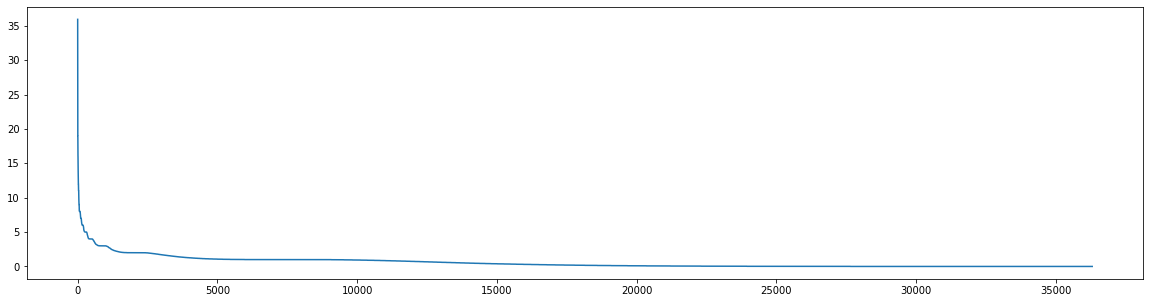

In [5]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

## Compute offline metrics

In [6]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)


# TODO 1: Implement MRR metric here

In [7]:
tracks = track_popularity["track"].tolist()

t_p_10_udf = lambda track: precision_at(tracks, track, 10)
st_10_p_10_udf = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10_udf = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10_udf = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["t_p_10_udf"] = metrics["track"].map(t_p_10_udf)
metrics["st_10_p_10_udf"] = metrics["track"].map(st_10_p_10_udf)
metrics["st_100_p_10_udf"] = metrics["track"].map(st_100_p_10_udf)
metrics["st_1000_p_10_udf"] = metrics["track"].map(st_1000_p_10_udf)

In [8]:
metrics[["t_p_10_udf", "st_10_p_10_udf", "st_100_p_10_udf", "st_1000_p_10_udf"]].describe()

,t_p_10_udf,st_10_p_10_udf,st_100_p_10_udf,st_1000_p_10_udf
count,16912.000000,16912.000000,16912.000000,16912.000000
mean,0.001171,0.001171,0.000491,0.000112
std,0.010757,0.010757,0.006989,0.003350
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


## Export data for prod

In [9]:
with open("/Users/n.anokhin/Desktop/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)